In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

In [ ]:
# ============================================================
# Parametri generali
# ============================================================

np.random.seed(0)           # Per riproducibilità

fs0 = 10000.0               # "frequenza di continuo" (Hz) - oversampling molto alto
dt  = 1.0 / fs0
T    = 5.0                  # durata del segnale in secondi
t    = np.arange(0, T, dt)
Ntot = len(t)

# Parametri banda
B   = 50.0                  # banda desiderata del segnale (Hz)
fc  = 2 * B                 # frequenza di campionamento critica (Nyquist)
N_os = 4                    # fattore di oversampling
fs_os = N_os * fc           # frequenza di campionamento sovracampionata

# Controllo che fs0 sia multiplo delle altre due (per semplicità)
assert fs0 % fc == 0, "fs0 deve essere multiplo di fc"
assert fs0 % fs_os == 0, "fs0 deve essere multiplo di fs_os"

Kc = int(fs0 / fc)          # passo di decimazione per campionamento critico
Kos = int(fs0 / fs_os)      # passo di decimazione per oversampling

# Parametri quantizzazione
q_bits = 4                  # numero di bit del quantizzatore
M = 2 ** q_bits             # livelli di quantizzazione

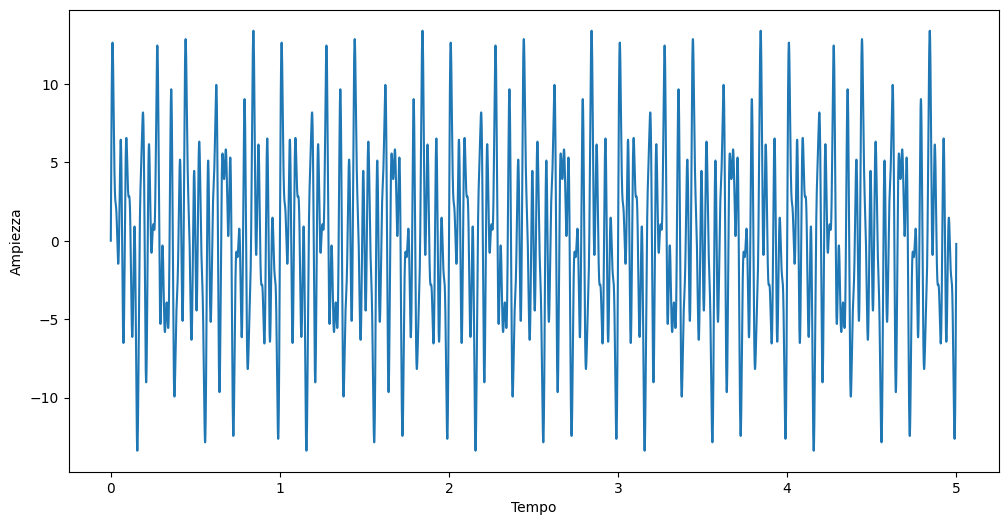

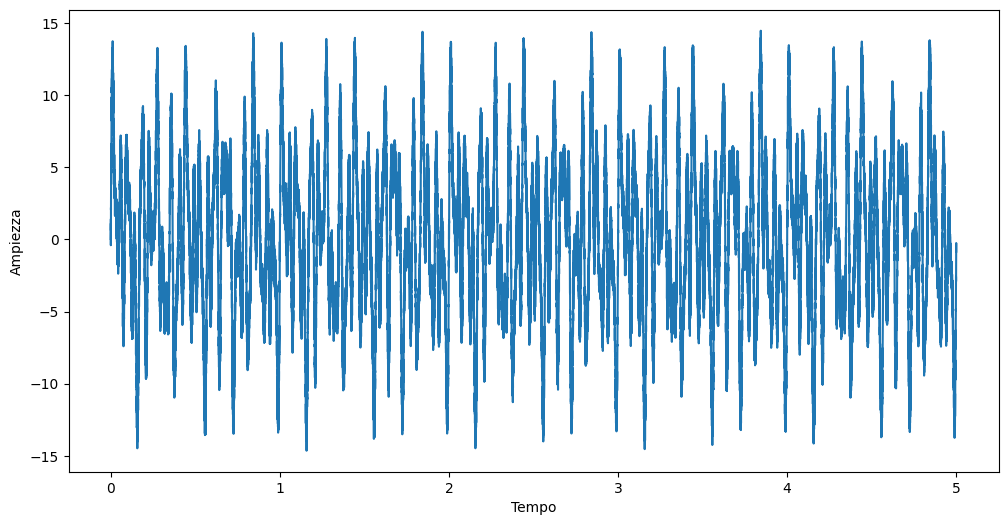

In [ ]:
# ============================================================
# 1) Generazione del segnale banda-limitata + rumore
# ============================================================

# Somma di sinusoidi con frequenze <= B
freqs = [5, 12, 18, 23, 37]  # tutte < B
amps  = [3, 4, 2, 5, 3]

x_clean = np.zeros_like(t)
for A, f in zip(amps, freqs):
    x_clean += A * np.sin(2 * np.pi * f * t)

plt.figure(figsize=(12, 6))
plt.plot(t, x_clean)
plt.xlabel("Tempo")
plt.ylabel("Ampiezza")

# Rumore gaussiano
noise = 0.5 * np.random.randn(Ntot)
x = x_clean + noise

plt.figure(figsize=(12, 6))
plt.plot(t, x)
plt.xlabel("Tempo")
plt.ylabel("Ampiezza")
plt.show()

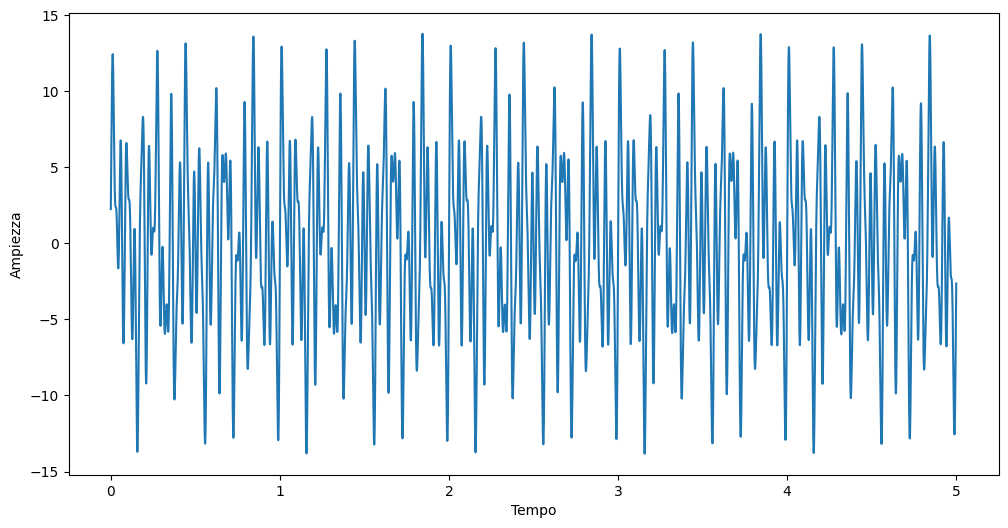

In [ ]:
# ============================================================
# 2) Filtro passa-basso per rendere x realmente banda-limitato
# ============================================================

# Progettiamo un filtro sinc ideale finestrato
# h(t) = 2B * sinc(2B t)
filter_half_width = 0.1  # secondi (larghezza temporale del filtro)
t_h = np.arange(-filter_half_width, filter_half_width, dt)
h = 2 * B * np.sinc(2 * B * t_h)  # np.sinc(x) = sin(pi x)/(pi x)

# Normalizzazione (opzionale, per mantenere il guadagno ~1)
h = h / np.sum(h)

# Filtraggio
x_f = convolve(x, h, mode='same')

plt.figure(figsize=(12, 6))
plt.plot(t, x_f)
plt.xlabel("Tempo")
plt.ylabel("Ampiezza")
plt.show()

In [ ]:
# ============================================================
# 3) Campionamento critico e sovracampionato
# ============================================================

# Campionamento critico
x_c = x_f[::Kc]
t_c = t[::Kc]

# Campionamento sovracampionato
x_os = x_f[::Kos]
t_os = t[::Kos]

In [ ]:
# ============================================================
# 4) Quantizzazione
# ============================================================

# Scelta dell'intervallo di quantizzazione basato sul segnale filtrato
Amax = np.max(np.abs(x_f))
Delta = 2 * Amax / M

# Livelli di quantizzazione (rappresentanti)
repr_levels = -Amax + Delta/2 + Delta * np.arange(M)

def quantize(x, levels):
    """
    Quantizzazione scalare esplicita:
    assegna ad ogni campione il livello più vicino.
    Implementazione con ciclo for, senza broadcasting.
    """
    x = np.asarray(x)
    levels = np.asarray(levels)

    quantized = np.zeros_like(x)

    for i in range(len(x)):
        sample = x[i]

        # inizializziamo con il primo livello come livello più vicino
        best_level = levels[0]
        best_dist  = abs(sample - levels[0])

        # cerchiamo il rappresentante più vicino
        for lev in levels[1:]:
            dist = abs(sample - lev)
            if dist < best_dist:
                best_dist = dist
                best_level = lev

        quantized[i] = best_level

    return quantized

# Quantizzazione delle due sequenze di campioni
x_cq  = quantize(x_c, repr_levels)
x_osq = quantize(x_os, repr_levels)
x_cq

array([  2.59295456,  12.96477282,   6.05022731,   2.59295456,
        -0.86431819,   0.86431819,   6.05022731,  -4.32159094,
        -4.32159094,   6.05022731,   4.32159094,   2.59295456,
        -2.59295456,  -6.05022731,   0.86431819,  -7.77886369,
       -12.96477282,  -0.86431819,   4.32159094,   7.77886369,
         0.86431819,  -9.50750006,   2.59295456,   4.32159094,
        -0.86431819,   0.86431819,   0.86431819,   9.50750006,
         9.50750006,  -4.32159094,  -2.59295456,  -0.86431819,
        -6.05022731,  -4.32159094,  -6.05022731,   2.59295456,
         9.50750006,  -6.05022731,  -9.50750006,  -4.32159094,
        -0.86431819,   6.05022731,  -2.59295456,  -0.86431819,
        12.96477282,   7.77886369,   2.59295456,  -2.59295456,
        -6.05022731,   4.32159094,   0.86431819,  -4.32159094,
         6.05022731,   2.59295456,  -2.59295456,  -7.77886369,
       -12.96477282,   0.86431819,   2.59295456,  -6.05022731,
        -0.86431819,   4.32159094,   9.50750006,   6.05

In [ ]:
# ============================================================
# 5) Ricostruzione: inserzione zeri + filtro sinc (stesso h)
# ============================================================

def reconstruct_from_samples(x_samp, K, h):
    """
    Ricostruisce un segnale a frequenza fs0 a partire da
    campioni x_samp presi ogni K campioni rispetto a fs0.
    Passi:
    - upsampling con zeri (inserzione zeri ogni K-1 campioni)
    - filtraggio con h (sinc) per interpolazione
    """
    up = np.zeros(Ntot)
    up[::K] = x_samp   # inserzione zeri
    x_rec = convolve(up, h, mode='same') * K
    return x_rec

# Ricostruzione senza quantizzazione
x_c_rec_noq  = reconstruct_from_samples(x_c,  Kc,  h)
x_os_rec_noq = reconstruct_from_samples(x_os, Kos, h)

# Ricostruzione con quantizzazione
x_c_rec_q  = reconstruct_from_samples(x_cq,  Kc,  h)
x_os_rec_q = reconstruct_from_samples(x_osq, Kos, h)

In [ ]:
# ============================================================
# 6) Calcolo errori (MSE)
# ============================================================

def mse(x_ref, x_hat):
    return np.mean((x_ref - x_hat)**2)

# Errori senza quantizzazione (solo dovuti a campionamento + filtro)
mse_c_noq  = mse(x_f, x_c_rec_noq)
mse_os_noq = mse(x_f, x_os_rec_noq)

# Errori con quantizzazione
mse_c_q  = mse(x_f, x_c_rec_q)
mse_os_q = mse(x_f, x_os_rec_q)

In [ ]:
# ============================================================
# 7) Stampa risultati
# ============================================================

print("================================================")
print("PARAMETRI:")
print(f"Durata T = {T} s, fs0 = {fs0} Hz, B = {B} Hz")
print(f"fc (critico)   = {fc} Hz")
print(f"fs_os (overs)  = {fs_os} Hz  (fattore N = {N_os})")
print(f"q_bits = {q_bits}, livelli M = {M}")
print("================================================")
print("ERRORI SENZA QUANTIZZAZIONE:")
print(f"MSE campionamento critico      = {mse_c_noq:.6e}")
print(f"MSE campionamento sovracampion = {mse_os_noq:.6e}")
print("------------------------------------------------")
print("ERRORI CON QUANTIZZAZIONE:")
print(f"MSE critico + quantizzazione      = {mse_c_q:.6e}")
print(f"MSE oversampling + quantizzazione = {mse_os_q:.6e}")
print("------------------------------------------------")
print("Confronto quantizzazione:")
print(f"Rapporto MSE_overs / MSE_critico = {mse_os_q / mse_c_q:.3f}")
print("================================================")

PARAMETRI:
Durata T = 5.0 s, fs0 = 10000.0 Hz, B = 50.0 Hz
fc (critico)   = 100.0 Hz
fs_os (overs)  = 400.0 Hz  (fattore N = 4)
q_bits = 4, livelli M = 16
ERRORI SENZA QUANTIZZAZIONE:
MSE campionamento critico      = 3.994802e-02
MSE campionamento sovracampion = 3.280604e-02
------------------------------------------------
ERRORI CON QUANTIZZAZIONE:
MSE critico + quantizzazione      = 2.766823e-01
MSE oversampling + quantizzazione = 8.222552e-02
------------------------------------------------
Confronto quantizzazione:
Rapporto MSE_overs / MSE_critico = 0.297


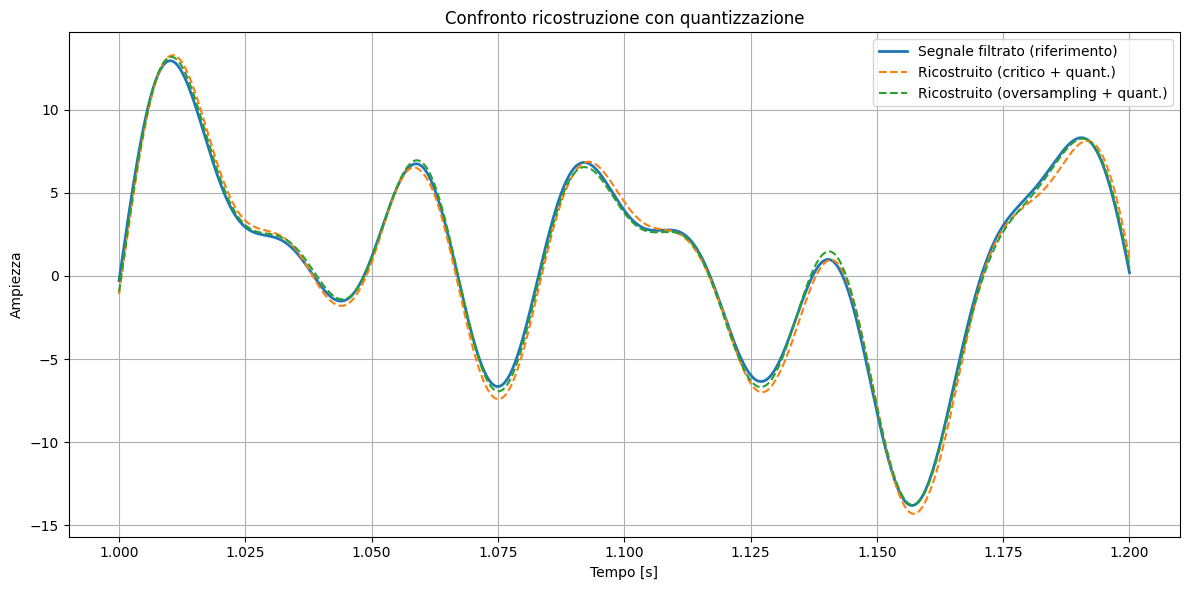

In [ ]:
# ============================================================
# 8) Grafici
# ============================================================

# Per non sovraccaricare le figure, mostriamo solo una finestra temporale
t_start = 1.0
t_end   = 1.2

def time_window(t, x, t0, t1):
    mask = (t >= t0) & (t <= t1)
    return t[mask], x[mask]

t_w, x_f_w        = time_window(t, x_f,        t_start, t_end)
_,   x_c_rec_w    = time_window(t, x_c_rec_q,  t_start, t_end)
_,   x_os_rec_w   = time_window(t, x_os_rec_q, t_start, t_end)

plt.figure(figsize=(12, 6))
plt.plot(t_w, x_f_w, label='Segnale filtrato (riferimento)', linewidth=2)
plt.plot(t_w, x_c_rec_w, '--', label='Ricostruito (critico + quant.)')
plt.plot(t_w, x_os_rec_w, '--', label='Ricostruito (oversampling + quant.)')
plt.xlabel("Tempo [s]")
plt.ylabel("Ampiezza")
plt.title("Confronto ricostruzione con quantizzazione")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()